<a href="https://colab.research.google.com/github/wellsalexandra/IGM-Phase/blob/main/modeFraction_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
def get_scaleArr(box):
  """ Return array of all simulated scale factors for a given box

  Kwargs:
  box - char/string of the simulatiom box label (either A,B,C, or F)
  """
  # assign directory
  directory = 'drive/MyDrive/UoM REU Project 2023/igm_phase_data/' + box
  files = np.empty(0)
  # iterate over files in
  # that directory
  for filename in os.scandir(directory):
      if filename.is_file():
        files = np.append(files, filename.path)

  files = np.sort(files)

  index = 0
  scales = np.zeros(len(files))

  #Extract scale factors:
  for i in range(len(files)):
    index = files[i].find("0.")
    strScale = files[i][index:index+6]
    scales[i] = float(strScale)

  return scales


def get_sampleArr(box):
  """ Return array of some simulated scale factors for a given box
  (Smaller array for testing)

  Kwargs:
  box - char/string of the simulatiom box label (either A,B,C, or F)
  """

  directory = 'drive/MyDrive/UoM REU Project 2023/igm_phase_data/' + box
  files = np.empty(0)
  # iterate over files in
  # that directory
  for filename in os.scandir(directory):
      if filename.is_file():
        files = np.append(files, filename.path)

  files = np.sort(files)

  index = 0
  sample = np.empty(0)

  #Extract scale factors:
  for i in range(len(files)):
    if i%5 == 0:
      index = files[i].find("0.")
      strSample = files[i][index:index+6]
      sample = np.append(sample, float(strSample))

  return sample


In [10]:
### Create full and smaller arrays for each box to use in following cells

A = get_scaleArr('A')
sampleA = get_sampleArr('A')

B = get_scaleArr('B')
sampleB = get_sampleArr('B')

C = get_scaleArr('C')
sampleC = get_sampleArr('C')

F = get_scaleArr('F')
sampleF = get_sampleArr('F')



In [12]:
def get_modeFraction(box, scale, density, method, cutoff=0):
  """ Return first/cold mode fraction of temperature PDF, given the required parameters

  Kwargs:
  box - char/string of the simulatiom box label (either A,B,C, or F)
  scale - scale factor (options within CROC-provided data)
  density - density bin
  method - mode separation method, either cut-off (1) or minimum (2)
  index - axis index of the subplot
  cutoff - For if the cut-off (1) method is selected, auto set to 0
  """

  arr = np.load("drive/MyDrive/UoM REU Project 2023/igm_phase_data/" + box + "/nT.a=" + str(scale).ljust(6, "0") +".bin.npy")

  tempProb = np.zeros(600)
  pulse1 = np.zeros(600)
  pulse2 = np.zeros(600)
  outlierLine = np.zeros(600)


  for i in range(600):
    tempProb[i] = arr[i, density]

  if(method == 1): #FOR CUT-OFF METHOD
    for i in range(600):
      if(i > 84 and i < 400): #create array in order to find the peak val of pulse 1
        pulse1[i] = tempProb[i]
      if(i >= 400): #create array in order to find the peak val of pulse 2
        pulse2[i] = tempProb[i]

    pulse1Max = pulse1.max()
    pulse2Max = pulse2.max()

    #Cut off everything below 10% of the maximum for each mode
    limit1 = pulse1Max * cutoff
    limit2 = pulse2Max * cutoff

    limitedHist = np.zeros(600)

    for i in range(600):
      if(i > 84 and i < 400): ### Now, separate the cut off and not cut off values for plotting the method
        if(tempProb[i] - limit1 >= 0):
          limitedHist[i] = (tempProb[i]-limit1)
          pulse1[i] = limitedHist[i]
      if(i >= 400):
        if(tempProb[i] - limit2 >= 0):
          limitedHist[i] = (tempProb[i]-limit2)
          pulse2[i] = limitedHist[i]

  elif(method == 2): ### FOR MINIMUM METHOD
    minRange = np.zeros(600)

    for i in range(600):
      if(i >= 38 and i < 415): # Ensuring that the minimum remains between the two mode peaks (as the peaks get closer and closer)
        minRange[i] = tempProb[i]

    minIndex = 380
    minVal = minRange[380]
    for i in range(380, 415):
      if(minRange[i] < minVal):
        minVal = minRange[i]
        minIndex = i

    pulse1 = np.zeros(600)
    pulse2 = np.zeros(600)

    for i in range(600):
      if(i < minIndex):
        pulse1[i] = tempProb[i]
      else:
        pulse2[i] = tempProb[i]

  pulse1Max = pulse1.max()
  pulse1MaxInd = np.argmax(pulse1)
  pulse2Max = pulse2.max()
  pulse2MaxInd = np.argmax(pulse2)

  pulse1sum = pulse1.sum()
  pulse2sum = pulse2.sum()

  pulse1Fraction = pulse1sum/(pulse1sum+pulse2sum)

  return pulse1Fraction


In [15]:
### This function is currently being used to plot ALL simulation boxes, so the box & arr arguements are not being used

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def plot_modeFraction(box, arr, densities):
  """ Plot first/cold mode fraction against scale factors

  Kwargs:
  box - char/string of the simulatiom box label (either A,B,C, or F)
  arr - array of scale factors
  densities- array of density bins
  method - mode separation method, either cut-off (1) or minimum (2)
  index - axis index of the subplot
  cutoff - For if the cut-off (1) method is selected, auto set to 0
  """

  densities = np.array(densities)
  fig = plt.figure()
  axis = plt.axes()

  A = get_scaleArr('A')
  B = get_scaleArr('B')
  C = get_scaleArr('C')
  F = get_scaleArr('F')

  modeFracsA = np.zeros([len(A)])
  modeFracsB = np.zeros([len(B)])
  modeFracsC = np.zeros([len(C)])
  modeFracsF = np.zeros([len(F)])

  for i in range(len(A)):
    modeFracsA[i] = get_modeFraction('A', A[i], 200, 1, 0.1)

  for i in range(len(B)):
    modeFracsB[i] = get_modeFraction('B', B[i], 200, 1, 0.1)

  for i in range(len(C)):
    modeFracsC[i] = get_modeFraction('C', C[i], 200, 1, 0.1)

  for i in range(len(F)):
    modeFracsF[i] = get_modeFraction('F', F[i], 200, 1, 0.1)

  ### convert density bins to log-scale density values
  densities = densities/100.0 - 2.0

  # read in rei.log files
  arrA = pd.read_csv("drive/MyDrive/UoM REU Project 2023/rei" + 'A' + ".log", sep = "\s+", usecols = [0, 13], names = ["scale", "neutral"], skiprows = 10)
  arrB = pd.read_csv("drive/MyDrive/UoM REU Project 2023/rei" + 'B' + ".log", sep = "\s+", usecols = [0, 13], names = ["scale", "neutral"], skiprows = 10)
  arrC = pd.read_csv("drive/MyDrive/UoM REU Project 2023/rei" + 'C' + ".log", sep = "\s+", usecols = [0, 13], names = ["scale", "neutral"], skiprows = 10)
  arrF = pd.read_csv("drive/MyDrive/UoM REU Project 2023/rei" + 'F' + ".log", sep = "\s+", usecols = [0, 13], names = ["scale", "neutral"], skiprows = 10)


  ### 'Fake' point in order to use legend
  mapfake, = axis.plot([-1, -2, -3], [1, 1, 1], color='black', linestyle='solid', linewidth=2.75)
  mapfakeR, = axis.plot([-1, -2, -3], [1, 1, 1], color='black', linestyle='solid', linewidth=1.25)

  map4, = axis.plot(F, modeFracsF, label="Box F - Mode 1 Fraction", linestyle='solid', linewidth=2.75,color='red')
  mapR4, = axis.plot(arrF["scale"], arrF["neutral"], linestyle='solid', linewidth=1.25, label = "Box F - Neutral Fraction", color = 'red')

  map2, = axis.plot(B, modeFracsB, label="Box B - Mode 1 Fraction", linestyle='dashed', linewidth=2.75, color='orange')
  mapR2,  = axis.plot(arrB["scale"], arrB["neutral"], linestyle='dashed', linewidth=1.25, label = "Box B - Neutral Fraction", color = 'orange')

  map1, = axis.plot(A, modeFracsA, label="Box A - Mode 1 Fraction", linestyle='dotted',linewidth=2.75, color = 'blue')
  mapR1, = axis.plot(arrA["scale"], arrA["neutral"], linestyle='dotted', linewidth=1.25, label = "Box A - Neutral Fraction", color = 'blue')

  map3, = axis.plot(C, modeFracsC, label="Box C - Mode 1 Fraction", linestyle='dashdot', linewidth=2.75,color='green')
  mapR3, = axis.plot(arrC["scale"], arrC["neutral"], linestyle='dashdot', linewidth=1.25, label = "Box C - Neutral Fraction", color = 'green')


  first_legend = axis.legend(handles=[map4, map2, map1, map3],labels= ['Late Reionization', 'Intermediate Reionization 1', 'Intermediate Reionization 2', 'Early Reionization'], loc='lower left', fontsize='large', framealpha=0.6)
  # Add the legend manually to the Axes.
  axis.add_artist(first_legend)
  axis.legend([mapfake, mapfakeR], ['Cold Fraction', 'Neutral Fraction'], loc='upper right', fontsize='large')

  axis.set_xlabel("Scale Factor", fontsize='xx-large')
  axis.set_ylabel("Fraction", fontsize='xx-large')
  axis.set_xlim(0.075, 0.14)

  plt.xticks(fontsize='large')
  axis.xaxis.set_minor_locator(MultipleLocator(0.002))
  plt.yticks(fontsize='large')
  axis.yaxis.set_minor_locator(MultipleLocator(0.04))

  # axis.set_title("Probability for each temperature for scale factor a=" + str(scale).ljust(6, "0"))
  # axis.set_title("Fractional Probability of Mode 1 across Scale Factors")

  plt.show(fig)



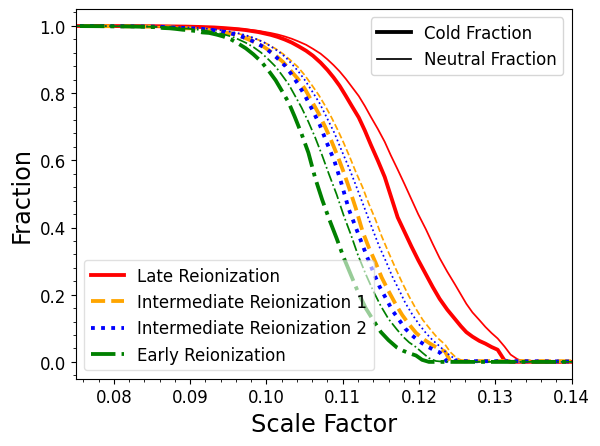

In [16]:
plot_modeFraction(A, 'A', np.arange(100,300,25))
